In [1]:
from IPython.display import Image
from IPython.display import display

# inline plotting instead of popping out
%matplotlib inline

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
import os, sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from lib import *

[nltk_data] Downloading package stopwords to /Users/peter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential() 
model.add(Dense(input_dim=512, output_dim=32))
model.add(Activation('relu'))
model.add(Dense(output_dim=1))
model.add(Activation('sigmoid'))

Using Theano backend.


In [4]:
'''model = Sequential([
    Dense(input_dim=512, output_dim=32),
    Activation('relu'),
    Dense(output_dim=1),
    Activation('sigmoid'),
])'''

"model = Sequential([\n    Dense(input_dim=512, output_dim=32),\n    Activation('relu'),\n    Dense(output_dim=1),\n    Activation('sigmoid'),\n])"

In [3]:
# for a binary classification problem

from keras.optimizers import SGD

# instantiate an optimizer with specific parameters
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9)
model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# or use default parameters
'''
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
'''

In [4]:
def gen_nn(input_dim=512, width=32, depth=2):
    model = Sequential()
    model.add(Dense(input_dim=input_dim, output_dim=width))
    model.add(Activation('relu'))
    for k in range(2, depth):
        model.add(Dense(output_dim=width))
        model.add(Activation('relu'))
    model.add(Dense(output_dim=1))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
from sklearn.datasets import fetch_20newsgroups

# we take 2 news groups:
# 1) rec : recreational activities (entertainment)
# 2) sci : science
categories = [
    'rec.autos',
    'rec.motorcycles',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.electronics',
    'sci.med',
    'sci.space',
]

# remove the following context, we only need the content
remove = ('headers', 'footers', 'quotes')

# after fetching the data
# content will store in newsgroups.data
# label will store in newsgroups.target
newsgroups = fetch_20newsgroups(subset='all', categories=categories,
                                     shuffle=True, random_state=0,
                                     remove=remove)

In [6]:
print('#Data size: %s' % np.shape(newsgroups.data))
print('Labels: %s' % np.unique(newsgroups.target))

#Data size: 7931
Labels: [0 1 2 3 4 5 6 7]


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# for simplicity, we only take 512 features
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), max_features=512, sublinear_tf=True, 
                             max_df=0.5, preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)

X = vectorizer.fit_transform(newsgroups.data).toarray()
y = (newsgroups.target > 3).astype(int) # sci

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# the dictionary map from word to feature index
dictionary = vectorizer.vocabulary_

# construct inverse_dictionary for later use
inverse_dictionary = {v: k for k, v in dictionary.items()}

In [27]:
import time

batch_size = 32

model = gen_nn(input_dim=X_train.shape[1])
%time his = model.fit(X_train, y_train, nb_epoch=400, \
                      batch_size=batch_size, \
                      validation_split=0.2, \
                      shuffle=True, verbose=0)
# evaluate trained model
score = model.evaluate(X_test, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

CPU times: user 36.9 s, sys: 3.37 s, total: 40.3 s
Wall time: 1min 6s

Test loss: 0.386
Test accuracy: 0.830


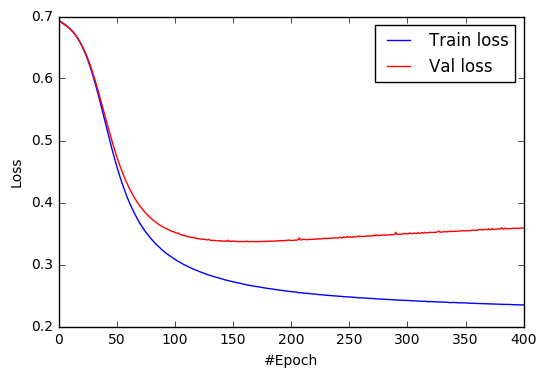

In [31]:
train_loss = his.history['loss']
val_loss = his.history['val_loss']

# visualize training history
plt.plot(range(1, len(train_loss)+1), train_loss, color='blue', label='Train loss')
plt.plot(range(1, len(val_loss)+1), val_loss, color='red', label='Val loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.savefig('./output/fig-nn-val.png', dpi=300)
plt.show()

In [34]:
model = gen_nn(input_dim=X_train.shape[1])
%time his = model.fit(X_train, y_train, nb_epoch=150, \
                      batch_size=batch_size, \
                      validation_split=0.2, \
                      shuffle=True, verbose=0)
# evaluate trained model
score = model.evaluate(X_test, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

CPU times: user 15.4 s, sys: 1.27 s, total: 16.7 s
Wall time: 16.1 s

Test loss: 0.357
Test accuracy: 0.834


CPU times: user 24.1 s, sys: 1.95 s, total: 26.1 s
Wall time: 26.4 s

Test loss: 0.360
Test accuracy: 0.834


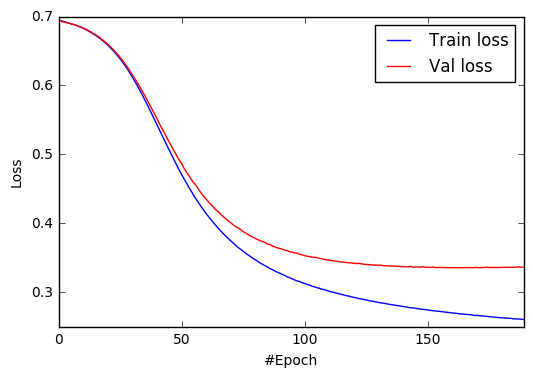

In [35]:
from keras.callbacks import EarlyStopping

model = gen_nn(input_dim=X_train.shape[1])

# monitor the validation loss
# min_delta : minimum change in the monitored quantity to qualify as an improvement
# patience : number of epochs with no improvement after which training will be stopped
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0)

%time his = model.fit(X_train, y_train, \
                      nb_epoch=1000, \
                      batch_size=batch_size, \
                      validation_split=0.2, \
                      shuffle=True, verbose=0, \
                      callbacks=[early_stop])

# evaluate trained model
score = model.evaluate(X_test, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

train_loss = his.history['loss']
val_loss = his.history['val_loss']

# visualize training history
plt.plot(range(1, len(train_loss)+1), train_loss, color='blue', label='Train loss')
plt.plot(range(1, len(val_loss)+1), val_loss, color='red', label='Val loss')
plt.xlim(0, len(train_loss))
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.savefig('./output/fig-nn-val-earlystop.png', dpi=300)
plt.show()

In [36]:
import gensim

# preprocess the text
corpus = []
for text in newsgroups.data:
    corpus.append(tokenizer_stem_nostop(preprocessor(text)))

# size : embed dimension
# min_count : filter words without min frequency
# sg : 0 for CBOW; 1 for skip-gram
# negative : how many noise words should be drawn
%time model_w2v = gensim.models.Word2Vec(corpus, size=64, min_count=5, sg=1, negative=5, workers=2)

CPU times: user 18.2 s, sys: 62.6 ms, total: 18.3 s
Wall time: 9.43 s


In [41]:
display(model_w2v.most_similar('car'))
display(model_w2v.most_similar('baseball'))
display(model_w2v.most_similar('electronic'))
display(model_w2v.most_similar('american'))

[('dealer', 0.8811931610107422),
 ('carnum', 0.8751373291015625),
 ('tires', 0.8727238178253174),
 ('auto', 0.8698107004165649),
 ('toyota', 0.8641738295555115),
 ('cars', 0.8555583953857422),
 ('nissan', 0.8509359359741211),
 ('taurus', 0.8422687649726868),
 ('sho', 0.8414863348007202),
 ('ford', 0.8391882181167603)]

[('football', 0.8458802103996277),
 ('basketball', 0.8432847857475281),
 ('manager', 0.8401429653167725),
 ('hockey', 0.8274414539337158),
 ('fans', 0.8264901041984558),
 ('comment', 0.8214669227600098),
 ('hockeynum', 0.8210901021957397),
 ('predictions', 0.8209678530693054),
 ('aaa', 0.8197799921035767),
 ('europeans', 0.8187340497970581)]

[('networks', 0.9103769063949585),
 ('identification', 0.9005450010299683),
 ('computer', 0.8913627862930298),
 ('bulletin', 0.8840085864067078),
 ('policies', 0.876185417175293),
 ('identity', 0.8623677492141724),
 ('universities', 0.8616251945495605),
 ('directories', 0.8612287640571594),
 ('administrative', 0.8588621020317078),
 ('businesses', 0.8577418327331543)]

[('national', 0.8200203776359558),
 ('america', 0.7982016801834106),
 ('association', 0.785031795501709),
 ('north', 0.7727607488632202),
 ('statenum', 0.7612690925598145),
 ('florida', 0.752049446105957),
 ('spanish', 0.7496165037155151),
 ('associationnum', 0.7446036338806152),
 ('california', 0.7414982318878174),
 ('city', 0.7405329942703247)]

In [42]:
display(model_w2v.most_similar(positive=['america', 'bmw'], negative=['europe']))

[('owner', 0.8814496397972107),
 ('camaro', 0.8321303129196167),
 ('mustang', 0.829980731010437),
 ('civic', 0.8181403279304504),
 ('owned', 0.8064216375350952),
 ('dodge', 0.7945497035980225),
 ('chevy', 0.7939352989196777),
 ('owners', 0.7933319211006165),
 ('honda', 0.7885527610778809),
 ('gt', 0.7798418998718262)]

In [43]:
display(model_w2v.most_similar(positive=['america', 'soccer'], negative=['europe']))

[('leaguenum', 0.9225832223892212),
 ('leagues', 0.9125382900238037),
 ('basketball', 0.907150149345398),
 ('championship', 0.9026291370391846),
 ('stanley', 0.8979941010475159),
 ('teamnum', 0.8915866613388062),
 ('afternoon', 0.8907722234725952),
 ('nba', 0.8903216123580933),
 ('franchise', 0.8889177441596985),
 ('expansion', 0.8884275555610657)]

In [44]:
def tfidf_word2vec_transform(model_w2v, embed_dim, inv_dic_tfidf, score_tfidf):
    tfidf_word2vec = np.zeros((score_tfidf.shape[0], embed_dim))
    for i in range(score_tfidf.shape[0]):
        doc_word2vec = np.zeros(embed_dim)
        for j in range(score_tfidf.shape[1]):
            doc_word2vec += score_tfidf[i, j] * model_w2v[inv_dic_tfidf[j]]
        tfidf_word2vec[i, :] = doc_word2vec
    return tfidf_word2vec

X_train_w2v = tfidf_word2vec_transform(model_w2v, 64, inverse_dictionary, X_train)
X_test_w2v = tfidf_word2vec_transform(model_w2v, 64, inverse_dictionary, X_test)

CPU times: user 18.1 s, sys: 130 ms, total: 18.2 s
Wall time: 18.5 s

Test loss: 0.366
Test accuracy: 0.831


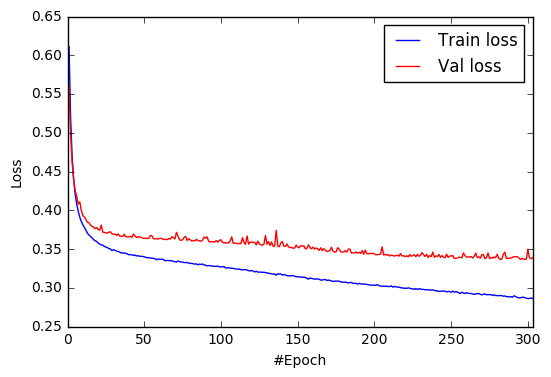

In [45]:
batch_size = 32

model = gen_nn(input_dim=X_train_w2v.shape[1])
        
%time his = model.fit(X_train_w2v, y_train, \
                      nb_epoch=1000, \
                      batch_size=batch_size, \
                      validation_split=0.2, \
                      shuffle=True, verbose=0, \
                      callbacks=[early_stop])

# evaluate trained model
score = model.evaluate(X_test_w2v, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
train_loss = his.history['loss']
val_loss = his.history['val_loss']

# visualize training history
plt.plot(range(1, len(train_loss)+1), train_loss, color='blue', label='Train loss')
plt.plot(range(1, len(val_loss)+1), val_loss, color='red', label='Val loss')
plt.xlim(0, len(train_loss))
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.savefig('./output/fig-nn-w2v-val.png', dpi=300)
plt.show()